In [68]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
from warnings import warn
from matplotlib.widgets import Slider
import time
from tqdm.notebook import tqdm,trange
%load_ext autoreload
%autoreload 2

from hungarian import preprocess, alternate, hungarian3, hungarian, augment
from transport import (gaussian_transport,
                       gaussian_discreatization,periodic_gaussian_discreatization,
                       uniform_disk_discretization)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Gaussian transport
## a) Display geodesic

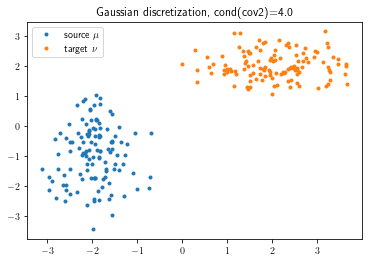

In [75]:
%matplotlib inline
rng = np.random.default_rng(1234)
d = 2
n=120
if d==2:
    mean1, mean2 = np.array([-2,-1]), np.array([2,2])
else:
    mean1, mean2 = rng.normal(size=d), rng.normal(size=d)
cov1, cov2 = 0.2*np.diag([1,4]), 0.2*np.diag([4,1])

transport, W_true = gaussian_transport(mean1, cov1, mean2, cov2)
mu, nu, C = gaussian_discreatization(mean1, cov1, mean2, cov2, n, rng)

if d==2:
    plt.plot(mu[:,0],mu[:,1],'.')
    plt.plot(nu[:,0],nu[:,1],'.')
    plt.title("Gaussian discretization")
    plt.legend(["source $\mu$","target $\\nu$"])
    plt.savefig("graphics/hungarian_mu_nu.pdf")

In [76]:
row,x,phi,U,V, W_hungarian = hungarian3(C)
print(W_hungarian)

hungarian3 succed (feasibility and complementary slackness holds)
25.240306650762328


W_true = 25.4
W_hungarian = 25.240306650762328
Error = -0.15969334923767065
cond(cov1)= 4.0 cond(cov12)= 4.0


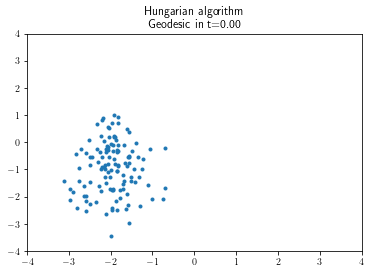

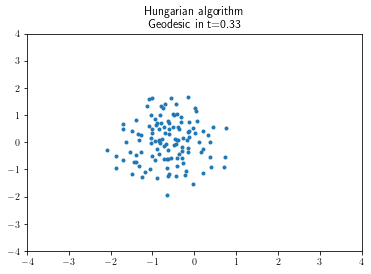

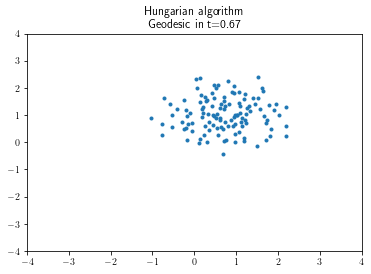

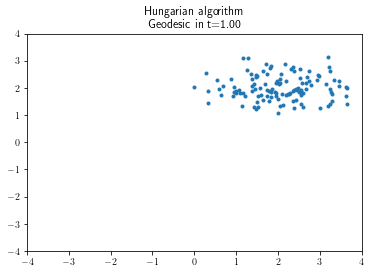

In [88]:
row = row.astype(np.int16)
print("W_true =",W_true)
#transported_mu = np.array([transport(mu[:,i] for i in range(n))]).T
#W_true_discretized = np.sum((mu[:,np.newaxis,:] - transported_mu)**2, axis=2) / n
print("W_hungarian =",W_hungarian)
print("Error =",W_hungarian-W_true)
print("cond(cov1)=",np.linalg.cond(cov1),"cond(cov12)=",np.linalg.cond(cov2))

if d==2:
    #plt.plot([mu[:,0],nu[row,0]],[mu[:,1],nu[row,1]],'blue')
    for i,t in enumerate(np.linspace(0,1,4)):
        plt.figure()
        xx = (1-t)*mu[:,0] + t*nu[phi,0]
        yy = (1-t)*mu[:,1] + t*nu[phi,1]
        plt.xlim((-4,4))
        plt.ylim((-4,4))
        plt.plot(xx,yy,".")
        plt.title(f"Hungarian algorithm \n Geodesic in t={t:.2f}")
        plt.savefig(f"graphics/hungarian_geodesic{i:d}.pdf")

In [89]:
%matplotlib
fig, (ax1,ax2) = plt.subplots(2)
s = Slider(ax = ax2, label = 'time', valmin = 0., valmax = 1., valinit = 0.)
def update(val):
    t=s.val
    xx = (1-t)*mu[:,0] + t*nu[phi,0]
    yy = (1-t)*mu[:,1] + t*nu[phi,1]
    ax1.cla()
    ax1.set_xlim((-5,5))
    ax1.set_ylim((-3,4))
    ax1.plot(xx,yy,'.')
s.on_changed(update)
update(0)
plt.show()

Using matplotlib backend: MacOSX


## b) Increase discretization

In [90]:
%matplotlib inline
rng = np.random.default_rng(12345)

transport_true, W_true = gaussian_transport(mean1, cov1, mean2, cov2)

nn = np.linspace(30,120,10).astype(int)
repeat = 20
runtime = np.zeros((len(nn),repeat))
error = np.zeros((len(nn),repeat))

for i,n in tqdm(enumerate(nn),total=len(nn)):
    for j in range(repeat):
        mu, nu, C = gaussian_discreatization(mean1, cov1, mean2, cov2, n, rng)
        tic = time.time()
        row,x,phi,U,V, W_hungarian = hungarian3(C,disp=False)
        runtime[i,j] = time.time() - tic
        error[i,j] = (W_hungarian - W_true) / W_true
runtime = np.vstack((np.mean(runtime,axis=1), np.std(runtime,axis=1)))
error = np.vstack((np.mean(error,axis=1), np.std(error,axis=1)))

  0%|          | 0/10 [00:00<?, ?it/s]

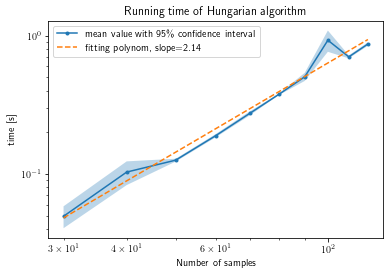

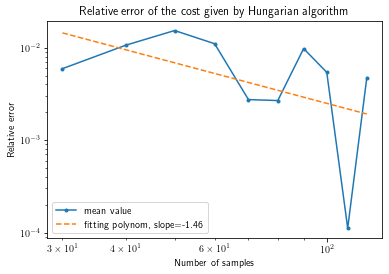

In [102]:
%matplotlib inline
conf_fact = 2.086/np.sqrt(repeat) # 95% confidence

plt.figure()
plt.plot(nn,runtime[0],'.-')
polynom = np.polyfit(np.log(nn),np.log(runtime[0]),deg=1)
plt.plot(nn,np.exp(polynom[1])*nn**polynom[0],"--")
plt.fill_between(nn,runtime[0]-conf_fact*runtime[1],runtime[0]+conf_fact*runtime[1],alpha=0.3)
plt.legend(["mean value with 95\% confidence interval",f"fitting polynom, slope={polynom[0]:.2f}"])
plt.yscale('log')
plt.xscale('log')
plt.title(f"Running time of Hungarian algorithm")
plt.xlabel("discretiration: number of samples")
plt.ylabel("time [s]")
plt.savefig("graphics/hungarian_time.pdf")

plt.figure()
error=np.abs(error)
plt.plot(nn,error[0],'.-')
polynom = np.polyfit(np.log(nn),np.log(error[0]),deg=1)
plt.plot(nn,np.exp(polynom[1])*nn**polynom[0],"--")
#plt.fill_between(nn,error[0]-conf_fact*error[1],error[0]+conf_fact*error[1],alpha=0.3)
plt.legend(["mean value",f"fitting polynom, slope={polynom[0]:.2f}"])
plt.yscale('log')
plt.xscale('log')
plt.title(f"Relative error of the cost given by Hungarian algorithm")
plt.xlabel("discretiration: number of samples")
plt.ylabel("Relative error")
plt.savefig("graphics/hungarian_error.pdf")

## c) dimensionality
### Gaussian

dim loop:   0%|          | 0/5 [00:00<?, ?it/s]

discretization loop:   0%|          | 0/5 [00:00<?, ?it/s]

discretization loop:   0%|          | 0/5 [00:00<?, ?it/s]

discretization loop:   0%|          | 0/5 [00:00<?, ?it/s]

discretization loop:   0%|          | 0/5 [00:00<?, ?it/s]

discretization loop:   0%|          | 0/5 [00:00<?, ?it/s]

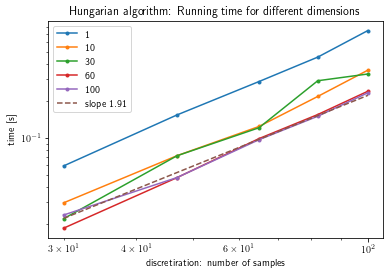

In [127]:
%matplotlib inline

rng = np.random.default_rng(1234)
dd = (np.linspace(1,10,5)**2).astype(int)
nn = np.linspace(30,100,5).astype(int)
lastruntime = np.zeros((len(dd),2))
plt.figure()
for idx_d,d in tqdm(enumerate(dd),total=len(dd),desc="dim loop", position=0):
    if d==2:
        mean1, mean2 = np.array([-2,-1]), np.array([2,2])
    else:
        mean1, mean2 = rng.normal(size=d), rng.normal(size=d)
    cov1, cov2 = np.eye(d), np.eye(d)

    transport, W_true = gaussian_transport(mean1, cov1, mean2, cov2)
    mu, nu, C = gaussian_discreatization(mean1, cov1, mean2, cov2, n, rng)
    transport_true, W_true = gaussian_transport(mean1, cov1, mean2, cov2)

    repeat = 20
    runtime = np.zeros((len(nn),repeat))
    error = np.zeros((len(nn),repeat))

    for i,n in tqdm(enumerate(nn),total=len(nn),desc="discretization loop", position=1, leave=False):
        for j in range(repeat):
            mu, nu, C = gaussian_discreatization(mean1, cov1, mean2, cov2, n, rng)
            tic = time.time()
            row,x,phi,U,V, W_hungarian = hungarian3(C,disp=False)
            runtime[i,j] = time.time() - tic
            error[i,j] = (W_hungarian - W_true) / W_true
    runtime = np.vstack((np.mean(runtime,axis=1), np.std(runtime,axis=1)))
    lastruntime[idx_d] = runtime[:,-1]
    error = np.vstack((np.mean(error,axis=1), np.std(error,axis=1)))
    plt.plot(nn,runtime[0],'.-')
    #polynom = np.polyfit(np.log(nn),np.log(runtime[0]),deg=1)
    #plt.plot(nn,np.exp(polynom[1])*nn**polynom[0],"--")
    #plt.fill_between(nn,runtime[0]-conf_fact*runtime[1],runtime[0]+conf_fact*runtime[1],alpha=0.3)

plt.yscale('log')
plt.xscale('log')
plt.title("Hungarian algorithm: Running time for different dimensions")
plt.xlabel("discretiration: number of samples")
plt.ylabel("time [s]")
polynom = np.polyfit(np.log(nn),np.log(runtime[0]),deg=1)
plt.plot(nn,np.exp(polynom[1])*nn**polynom[0],"--")
plt.legend(np.append(dd.astype(str),f"slope {polynom[0]:.2f}"))
plt.savefig("graphics/hungarian_dimensions.pdf")

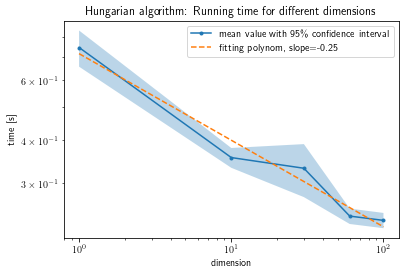

In [137]:
plt.loglog(dd,lastruntime[:,0],'.-')
polynom = np.polyfit(np.log(dd),np.log(lastruntime[:,0]),deg=1)
plt.plot(dd,np.exp(polynom[1])*dd**polynom[0],"--")
plt.fill_between(dd,lastruntime[:,0]-conf_fact*lastruntime[:,1],lastruntime[:,0]+conf_fact*lastruntime[:,1],alpha=0.3)
plt.legend(["mean value with 95\% confidence interval",f"fitting polynom, slope={polynom[0]:.2f}"])
plt.title("Hungarian algorithm: Running time for different dimensions")
plt.xlabel("dimension")
plt.ylabel("time [s]")
plt.savefig("graphics/hungarian_dimensionality.pdf")

# 2. Periodic Gaussian transport

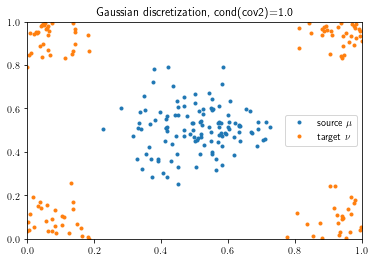

In [142]:
%matplotlib inline
rng = np.random.default_rng(1234)
d = 2
n=120
sigma = 0.01
mean1 , cov1 = 0.5 * np.ones((2)) , sigma * np.eye(2)
mean2 , cov2 = 1 * np.ones((2)) , sigma * np.eye(2)

transport, W_true = gaussian_transport(mean1, cov1, mean2, cov2)
mu, nu, C = periodic_gaussian_discreatization(mean1, cov1, mean2, cov2, n, rng)

plt.plot(mu[:,0],mu[:,1],'.')
plt.title("Gaussian discretization, cond(cov1)="+str(np.linalg.cond(cov1)))
plt.plot(nu[:,0],nu[:,1],'.')
plt.xlim((0,1))
plt.ylim((0,1))
plt.title("Gaussian discretization, cond(cov2)="+str(np.linalg.cond(cov2)))
plt.legend(["source $\mu$","target $\\nu$"])
plt.savefig("graphics/hungarian_periodicgaussiandiscretization.pdf")

In [143]:
row,x,phi,U,V, W_hungarian = hungarian3(C,tol=1e-5)
print(W_hungarian)

hungarian3 succed (feasibility and complementary slackness holds)
27.875515646601357


W_true = 0.5000000000000001
W_hungarian = 27.875515646601357
Error = 27.375515646601357
cond(cov1)= 1.0 cond(cov12)= 1.0


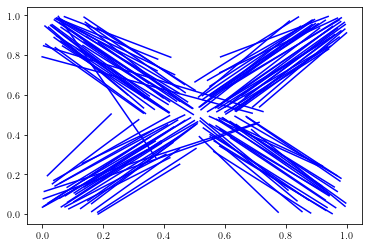

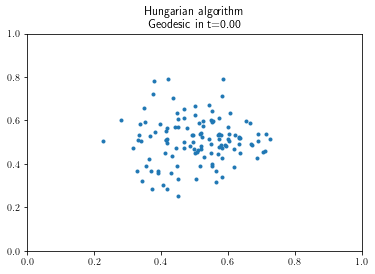

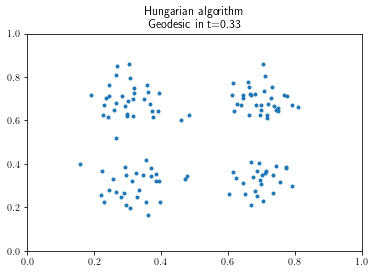

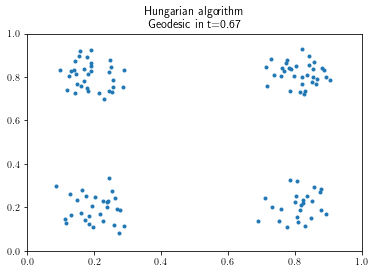

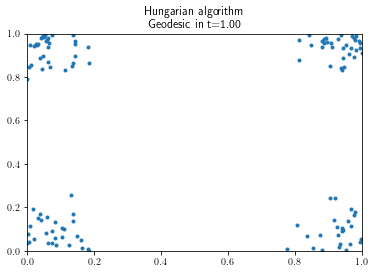

In [145]:
%matplotlib inline
phi = phi.astype(np.int16)
print("W_true =",W_true)
#transported_mu = np.array([transport(mu[:,i] for i in range(n))]).T
#W_true_discretized = np.sum((mu[:,np.newaxis,:] - transported_mu)**2, axis=2) / n
print("W_hungarian =",W_hungarian)
print("Error =",W_hungarian-W_true)
print("cond(cov1)=",np.linalg.cond(cov1),"cond(cov12)=",np.linalg.cond(cov2))

plt.plot([mu[:,0],nu[phi,0]],[mu[:,1],nu[phi,1]],'blue')

for i,t in enumerate(np.linspace(0,1,4)):
    plt.figure()
    xx = (1-t)*mu[:,0] + t*nu[phi,0]
    yy = (1-t)*mu[:,1] + t*nu[phi,1]
    plt.xlim((0,1))
    plt.ylim((0,1))
    plt.plot(xx,yy,'.')
    plt.title(f"Hungarian algorithm \n Geodesic in t={t:.2f}")
    plt.savefig(f"graphics/hungarian_geodesicperiodic{i:d}.pdf")

In [147]:
%matplotlib
fig, (ax1,ax2) = plt.subplots(2)
s = Slider(ax = ax2, label = 'time', valmin = 0., valmax = 1., valinit = 0.)
def update(val):
    t=s.val
    xx = (1-t)*mu[:,0] + t*nu[phi,0]
    yy = (1-t)*mu[:,1] + t*nu[phi,1]
    ax1.cla()
    ax1.set_xlim((0,1))
    ax1.set_ylim((0,1))
    ax1.plot(xx,yy,'.')
s.on_changed(update)
update(0)
plt.show()

Using matplotlib backend: MacOSX


# Uniform transport

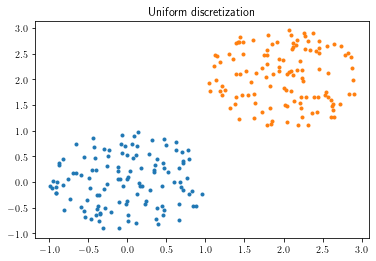

In [154]:
%matplotlib inline
rng = np.random.default_rng(1234)
d = 2
n = 120

mu, nu, C = uniform_disk_discretization(n,d,rng)
shift=2
nu = nu + shift


if d==2:
    transport, W_true = lambda x: x+shift , 2*shift**2
    plt.plot(mu[:,0],mu[:,1],'.')
    plt.title("Uniform discretization")
    plt.plot(nu[:,0],nu[:,1],'.')
    plt.title("Uniform discretization")

In [155]:
row,x,phi,U,V, W_hungarian = hungarian3(C)
print(W_hungarian)

hungarian3 succed (feasibility and complementary slackness holds)
0.02495567957042743


W_true = 8
W_hungarian = 0.02495567957042743
Error = -7.975044320429572


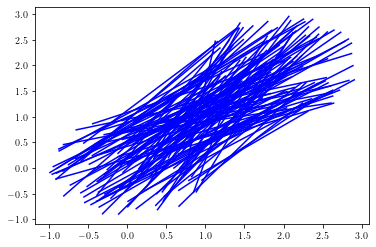

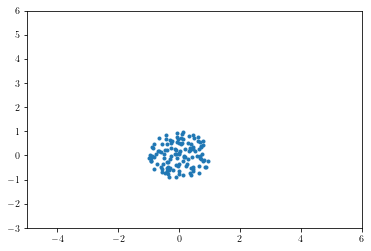

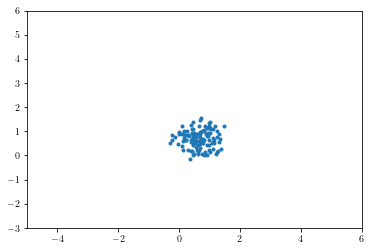

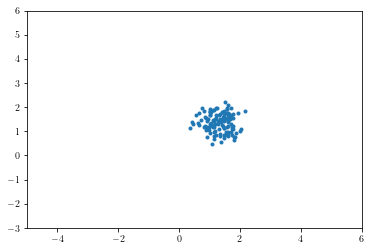

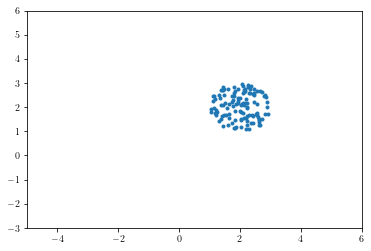

In [156]:
row = row.astype(np.int16)
print("W_true =",W_true)
#transported_mu = np.array([transport(mu[:,i] for i in range(n))]).T
#W_true_discretized = np.sum((mu[:,np.newaxis,:] - transported_mu)**2, axis=2) / n
print("W_hungarian =",W_hungarian)
print("Error =",W_hungarian-W_true)

if d==2:
    plt.plot([mu[:,0],nu[row,0]],[mu[:,1],nu[row,1]],'blue')
    for i,t in enumerate(np.linspace(0,1,4)):
        plt.figure()
        xx = (1-t)*mu[:,0] + t*nu[row,0]
        yy = (1-t)*mu[:,1] + t*nu[row,1]
        plt.xlim((-5,6))
        plt.ylim((-3,6))
        plt.plot(xx,yy,'.')

In [151]:
%matplotlib
fig, (ax1,ax2) = plt.subplots(2)
s = Slider(ax = ax2, label = 'time', valmin = 0., valmax = 1., valinit = 0.)
def update(val):
    t=s.val
    xx = (1-t)*mu[:,0] + t*nu[phi,0]
    yy = (1-t)*mu[:,1] + t*nu[phi,1]
    ax1.cla()
    ax1.set_xlim((-2,5))
    ax1.set_ylim((-2,5))
    ax1.plot(xx,yy,'.')
s.on_changed(update)
update(0)
plt.show()

Using matplotlib backend: MacOSX


In [152]:
%matplotlib inline
rng = np.random.default_rng(12345)

transport_true, W_true = lambda x: x+2 , 8

nn = np.linspace(30,120,10).astype(int)
repeat = 20
runtime = np.zeros((len(nn),repeat))
error = np.zeros((len(nn),repeat))

for i,n in tqdm(enumerate(nn),total=len(nn)):
    for j in range(repeat):
        mu, nu, C = uniform_disk_discretization(n,d,rng)
        tic = time.time()
        row,x,phi,U,V, W_hungarian = hungarian3(C,disp=False)
        runtime[i,j] = time.time() - tic
        error[i,j] = (W_hungarian - W_true) / W_true
runtime = np.vstack((np.mean(runtime,axis=1), np.std(runtime,axis=1)))
error = np.vstack((np.mean(error,axis=1), np.std(error,axis=1)))

  0%|          | 0/10 [00:00<?, ?it/s]

Text(0, 0.5, 'Relative error')

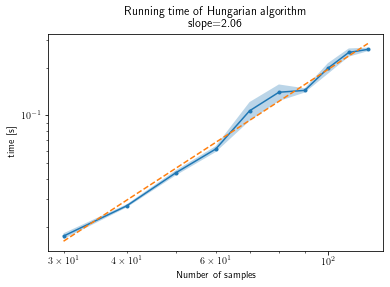

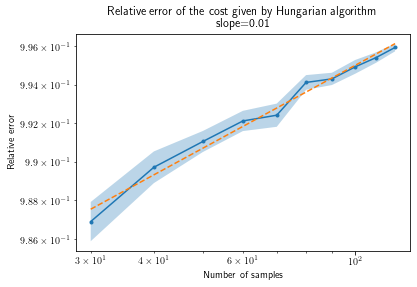

In [153]:
%matplotlib inline
conf_fact = 0.99/np.sqrt(repeat) # 
transport_true, W_true = lambda x: x+2 , 8
plt.figure()
plt.plot(nn,runtime[0],'.-')
polynom = np.polyfit(np.log(nn),np.log(runtime[0]),deg=1)
plt.plot(nn,np.exp(polynom[1])*nn**polynom[0],"--")
plt.fill_between(nn,runtime[0]-conf_fact*runtime[1],runtime[0]+conf_fact*runtime[1],alpha=0.3)
plt.yscale('log')
plt.xscale('log')
plt.title(f"Running time of Hungarian algorithm \n slope={polynom[0]:.2f}")
plt.xlabel("Number of samples")
plt.ylabel("time [s]")

plt.figure()
error=np.abs(error)
plt.plot(nn,error[0],'.-')
polynom = np.polyfit(np.log(nn),np.log(error[0]),deg=1)
plt.plot(nn,np.exp(polynom[1])*nn**polynom[0],"--")
plt.fill_between(nn,error[0]-conf_fact*error[1],error[0]+conf_fact*error[1],alpha=0.3)
plt.yscale('log')
plt.xscale('log')
plt.title(f"Relative error of the cost given by Hungarian algorithm \n slope={polynom[0]:.2f}")
plt.xlabel("Number of samples")
plt.ylabel("Relative error")